In [1]:
import numpy as np
from keras_preprocessing.sequence import pad_sequences
import numpy as np 
import tensorflow as tf
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
#from keras.preprocessing.text import Tokenizer|
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.datasets import imdb


In [92]:
seed = 7
print(seed)

7


# Загрузка данных

In [93]:
from sklearn.model_selection import train_test_split
from keras.datasets import imdb

# Загрузка данных
max_features = 2000
(x_data1, y_data1), (x_data2, y_data2) = imdb.load_data(num_words=max_features,seed=seed)

In [94]:
max_review_length = 300
x_data = np.concatenate([x_data1, x_data2], axis=0)
y_data = np.concatenate([y_data1, y_data2], axis=0)
x_data = pad_sequences(x_data, maxlen=max_review_length,value = 0,padding = 'post', truncating='post')
x_data = x_data[:int(len(x_data))]
y_data = y_data[:int(len(y_data))]

Загружаем все данные, объединяем в один датасмет из 50000 записей

In [95]:

x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.15, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)

# Проверка размеров выборок
print(x_train.shape, x_val.shape, x_test.shape)

(42500, 300) (6000, 300) (1500, 300)


Разделяем на тренировочную, тестовую и валидационную.

Одномерная свёрточная сеть

In [96]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D,MaxPooling1D, Dense, Dropout
from keras import regularizers
embedding_vecor_length = 300
# Модель
model_cnn = Sequential([
    Embedding(input_dim=max_features, output_dim=embedding_vecor_length,input_length=max_review_length),
    Conv1D(filters=128, kernel_size=9, activation='relu'),
    #MaxPooling1D(5),
    #Conv1D(filters=64, kernel_size=5, activation='relu'),Dropout(0.5),
    GlobalMaxPooling1D(),

    Dense(1, activation='sigmoid',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()
# Обучение



Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 300, 300)          600000    
                                                                 
 conv1d_7 (Conv1D)           (None, 292, 128)          345728    
                                                                 
 global_max_pooling1d_7 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 945857 (3.61 MB)
Trainable params: 945857 (3.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Сеть состоит из слоя эмбединга, преобразующего целые числа в векторные представления; свёрточного слоя с ядром 9  и 128 фильтрами, объединяющего слоя и финального слоя из одного нейрона.

Такая сеть показала наилучшие результаты по сравнению с более сложными.

In [97]:
# Обучение
history_cnn  = model_cnn.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,verbose =1,validation_data=(x_val,y_val)
)

Epoch 1/10
665/665 [==============================] - 81s 121ms/step - loss: 0.3653 - accuracy: 0.8315 - val_loss: 0.2743 - val_accuracy: 0.8842
Epoch 2/10
665/665 [==============================] - 81s 122ms/step - loss: 0.2145 - accuracy: 0.9156 - val_loss: 0.2593 - val_accuracy: 0.8902
Epoch 3/10
665/665 [==============================] - 79s 119ms/step - loss: 0.1325 - accuracy: 0.9552 - val_loss: 0.2721 - val_accuracy: 0.8933
Epoch 4/10
665/665 [==============================] - 80s 121ms/step - loss: 0.0613 - accuracy: 0.9863 - val_loss: 0.2958 - val_accuracy: 0.8895
Epoch 5/10
665/665 [==============================] - 80s 120ms/step - loss: 0.0216 - accuracy: 0.9980 - val_loss: 0.3384 - val_accuracy: 0.8900
Epoch 6/10
665/665 [==============================] - 78s 117ms/step - loss: 0.0075 - accuracy: 0.9999 - val_loss: 0.3750 - val_accuracy: 0.8917
Epoch 7/10
665/665 [==============================] - 77s 115ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.4106 - val_ac

Посл обучения получаем accuracy 1 на тренировочной выборке и 0.89  на валидационной. ЧТо говорит  о том что сеть хорошо обучилась

# Полносвязная сеть с GLOVE

In [98]:
import os
import urllib.request
import zipfile

# Папка для хранения GloVe
glove_dir = './glove'

if not os.path.exists(glove_dir):
    os.makedirs(glove_dir)

# URL для скачивания GloVe
glove_url = 'http://nlp.stanford.edu/data/glove.6B.zip'
glove_zip_path = os.path.join(glove_dir, 'glove.6B.zip')

# Скачивание
if not os.path.exists(glove_zip_path):
    print("Скачивание GloVe...")
    urllib.request.urlretrieve(glove_url, glove_zip_path)

# Распаковка
if not os.path.exists(os.path.join(glove_dir, 'glove.6B.300d.txt')):
    print("Распаковка GloVe...")
    with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
        zip_ref.extractall(glove_dir)

print("GloVe готов к использованию.")

GloVe готов к использованию.


Скачиваем данные Glove - самые маленькие

In [99]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
import numpy as np

# Загрузка GloVe
embedding_dim = 300
glove_file = './glove/glove.6B.300d.txt'
embeddings_index = {}

with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

Создали словарь векторных представлений

In [100]:
# Создание матрицы эмбеддингов
word_index = imdb.get_word_index()
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    if i < max_features:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Строим матрицу векторных представлений

In [104]:
# Построение полносвязной сети
model_dense = Sequential([
    Embedding(input_dim=max_features,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_review_length,
              trainable=False,mask_zero = True),
    Flatten(),

    Dense(1, activation='sigmoid')
])

# Компиляция модели
model_dense.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_dense.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 300, 300)          600000    
                                                                 
 flatten_11 (Flatten)        (None, 90000)             0         
                                                                 
 dense_22 (Dense)            (None, 1)                 90001     
                                                                 
Total params: 690001 (2.63 MB)
Trainable params: 90001 (351.57 KB)
Non-trainable params: 600000 (2.29 MB)
_________________________________________________________________


Создаём полносвязную модель. В неё мы загружаем полученые веса в слой Embeding и запрещаем его изменять, после чего выпрямляем данные и передаём на выходной нейрон. Здесь аналогично лучший результат показала сеть с одним полносвязным нейроном и отсуствием регуляризаций.

In [105]:
# Обучение модели
history_dense = model_dense.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, y_val),
    verbose=1
)

Epoch 1/10
333/333 [==============================] - 5s 13ms/step - loss: 0.7556 - accuracy: 0.5738 - val_loss: 0.9493 - val_accuracy: 0.5830
Epoch 2/10
333/333 [==============================] - 4s 13ms/step - loss: 0.5630 - accuracy: 0.7168 - val_loss: 1.0348 - val_accuracy: 0.5802
Epoch 3/10
333/333 [==============================] - 4s 13ms/step - loss: 0.4659 - accuracy: 0.7760 - val_loss: 0.7897 - val_accuracy: 0.6253
Epoch 4/10
333/333 [==============================] - 4s 13ms/step - loss: 0.3950 - accuracy: 0.8194 - val_loss: 0.8455 - val_accuracy: 0.6213
Epoch 5/10
333/333 [==============================] - 4s 13ms/step - loss: 0.3306 - accuracy: 0.8593 - val_loss: 0.8643 - val_accuracy: 0.6230
Epoch 6/10
333/333 [==============================] - 4s 13ms/step - loss: 0.3001 - accuracy: 0.8756 - val_loss: 0.9599 - val_accuracy: 0.6170
Epoch 7/10
333/333 [==============================] - 4s 13ms/step - loss: 0.2776 - accuracy: 0.8860 - val_loss: 0.9320 - val_accuracy: 0.6187

После обучения сеть показывает accuracy 0.92 на тестовой выборке, и 0.6 на валидационной

# Оценка моделей

In [106]:
from sklearn.metrics import classification_report, f1_score
y_pred_cnn = (model_cnn.predict(x_test) > 0.5).astype(int)
y_pred_dense = (model_dense.predict(x_test) > 0.5).astype(int)

47/47 [==============================] - 0s 2ms/step


## Результат на тестовой выборке

In [107]:
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn,zero_division=0))

CNN Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       778
           1       0.88      0.91      0.90       722

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



Свёрточная сеть показывает хорошие результаты по всем параметрам

In [108]:
print("Dense Classification Report:")
print(classification_report(y_test, y_pred_dense,zero_division=0))

Dense Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.38      0.50       778
           1       0.56      0.84      0.67       722

    accuracy                           0.60      1500
   macro avg       0.64      0.61      0.58      1500
weighted avg       0.64      0.60      0.58      1500



У полносвязной сети результаты хуже, особенно плохи recall у 0 класса, и precision у 1 класса.

## Графики обучения


In [120]:
def plot_history(history, title):
    plt.figure(figsize=(12, 5))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

### Свёрточная сеть

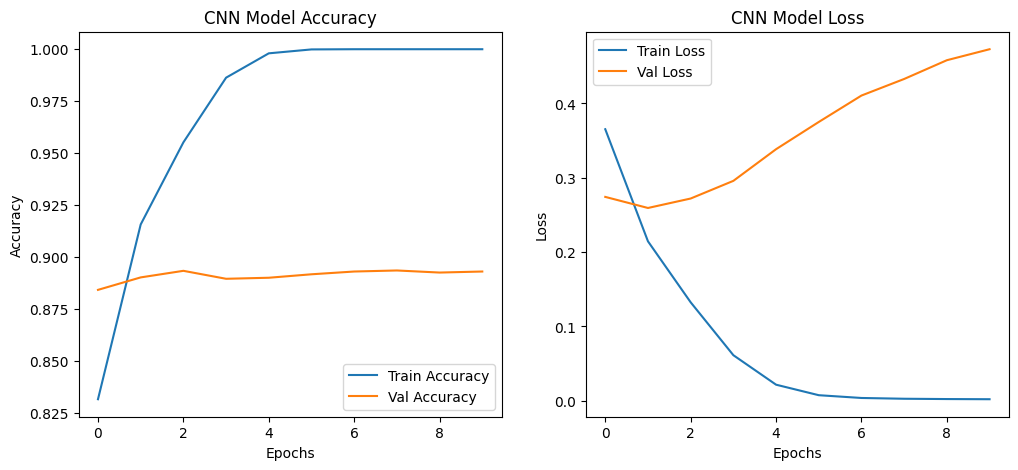

In [121]:
plot_history(history_cnn, 'CNN Model')

По графику вижно что в результате обучения сенть улучшила свой результат немного, при этов выросли потери на валидационной выборке. Те сеть переобучалась, но продолжала показывать тот-же или чуть лучший результат на валидационной выборке.

### Полносвязная с предобучением

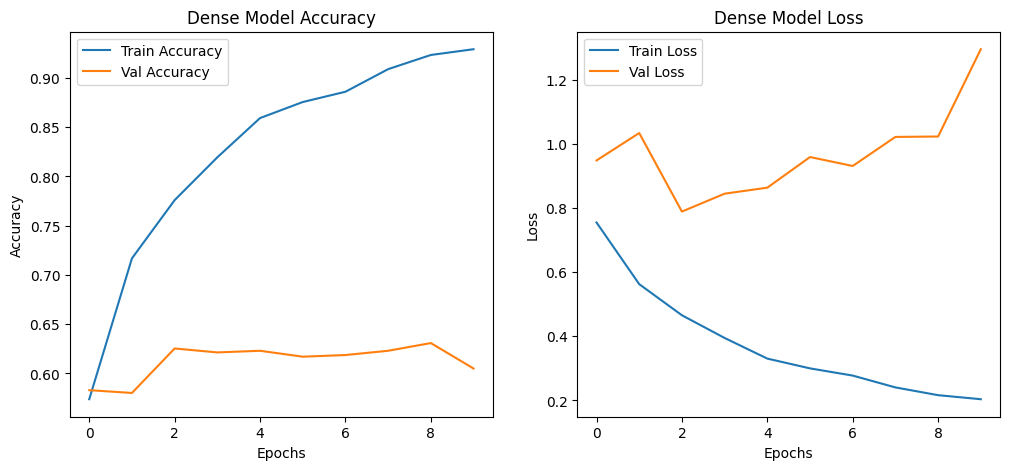

In [122]:
plot_history(history_dense, 'Dense Model')

В полносвязной сети всё происходи аналогично, но тк у нас и так есть много данных на вход, то большого влияния предварительно обученные векторные представления не оказали.

# Выводы

Сравнили две модели для задачи классификации текста: одномерная сверточная нейронна сеть и предобученная полносвязная нейронная сеть. 

Для сверточной модели результаты: Test Accuracy: 90%, f1-score  в среднем: 0.57

Для полносвязной модели результаты: Test Accuracy: 60%, f1-score  в среднем: 0.58

Обе сети переобучаются, но свёрточная сеть показывает лучшие результаты по сравнению с полносвязной. С регуляризацией обе сети показывыают результаты хуже на 10-20 процентов.